# 8.2 Tensorflow and Keras

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# for loading images
from tensorflow.keras.preprocessing.image import load_img

In [6]:
path = "clothing-dataset-small/train/t-shirt"
name = "00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg"
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(299, 299))

In [7]:
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7916F258DD60>


In [8]:
# we can see this image as a numpy array due to how theyre represented internally (matrices of RGB)
x = np.array(img)
x.shape

(299, 299, 3)

# 8.3 Pre-trained Convolutional Neural Networks

In [9]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [13]:
# xception mdoel from keras
model = Xception(
    weights="imagenet",
    input_shape=(299,299,3)
)

# array of images
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [14]:
X = preprocess_input(X)
X[0]

array([[[-0.18431371, -0.84313726, -0.92156863],
        [-0.17647058, -0.8352941 , -0.9137255 ],
        [-0.17647058, -0.8352941 , -0.9137255 ],
        ...,
        [-0.6627451 , -0.7254902 , -0.7411765 ],
        [-0.67058825, -0.73333335, -0.7490196 ],
        [-0.69411767, -0.75686276, -0.77254903]],

       [[-0.17647058, -0.8352941 , -0.9137255 ],
        [-0.17647058, -0.8352941 , -0.9137255 ],
        [-0.16862744, -0.827451  , -0.90588236],
        ...,
        [-0.6784314 , -0.7411765 , -0.75686276],
        [-0.6784314 , -0.7411765 , -0.75686276],
        [-0.6862745 , -0.7490196 , -0.7647059 ]],

       [[-0.16862744, -0.827451  , -0.90588236],
        [-0.16862744, -0.827451  , -0.90588236],
        [-0.1607843 , -0.81960785, -0.8980392 ],
        ...,
        [-0.67058825, -0.73333335, -0.7490196 ],
        [-0.6784314 , -0.7411765 , -0.75686276],
        [-0.7019608 , -0.7647059 , -0.78039217]],

       ...,

       [[-0.3098039 , -0.47450978, -0.6862745 ],
        [-0

In [17]:
pred = model.predict(X)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(1, 1000)

In [18]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.88808084),
  ('n03710637', 'maillot', 0.0068297414),
  ('n04456115', 'torch', 0.0064490745),
  ('n02730930', 'apron', 0.00592232),
  ('n04235860', 'sleeping_bag', 0.005410174)]]

# 8.4 Convolutional Neural Networks

Convolutional Layers consist of filters(like small images). These images contain simple shapes(like lines).

Sliding a filter onto an image gets us a feature map that represents the filter's similarity to the parts(pixels) of the image. This means that there is one(1) feature map per filter.

Passing an image to a CNN layer will produce a vector representation of the image.

After turning the image into a vector by using the convolutional layers, we can use the dense layers to make the final prediction. Basically, the role of dense layers is to make the prediction. It is called the dense layer because of how dense the connections are in this phase of the neural network. For example, the input(features from vector) is connected to every output(in a multiclass classification). *You can have multiple dense layers*

In the case of identifying whether the object in the image is a t-shirt, the dense layer will make use of binary classification techniques.

Sidenote: Sigmoid for multiple classes is called **SOFTMAX**

# 8.5 Transfer Learning

Remember, **convolutional layers** are generic while the **dense layers** are specific to the dataset. That said, we would like to train here the dense layers to achieve what we want. That is, predicting the type of clothing the object in an image is.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory('clothing-dataset-small/train', 
                              target_size=(150, 150), 
                              batch_size=32)

Found 3070 images belonging to 10 classes.


In [21]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [22]:
X, y = next(train_ds)

In [23]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

It can be seen that it uses *one-hot encoding* for the label

In [24]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('clothing-dataset-small/validation', 
                              target_size=(150, 150), 
                              batch_size=32, 
                              shuffle=False)

Found 341 images belonging to 10 classes.


In [25]:
# set include_top false to not include the dense layers in training
base_model = Xception(weights="imagenet", 
                      include_top=False, 
                      input_shape=(150, 150, 3))
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [26]:
model

<Functional name=functional, built=True>

In [28]:
print(type(model))

<class 'keras.src.models.functional.Functional'>


In [29]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [30]:
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/home/kabs/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733409503.114859   31476 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3717', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1733409503.135597   31475 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3717', 352 bytes spill stores, 352 bytes spill loads



95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5761 - loss: 1.7553

I0000 00:00:1733409510.947017   31526 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3717', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1733409511.108378   31523 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3717', 424 bytes spill stores, 348 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5771 - loss: 1.7503

I0000 00:00:1733409517.555159   31622 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1042', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1733409517.658389   31617 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1042', 424 bytes spill stores, 348 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.5781 - loss: 1.7453 - val_accuracy: 0.7449 - val_loss: 0.9210
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8167 - loss: 0.5713 - val_accuracy: 0.7566 - val_loss: 1.1106
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8772 - loss: 0.3610 - val_accuracy: 0.7977 - val_loss: 0.8800
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9143 - loss: 0.2302 - val_accuracy: 0.7771 - val_loss: 1.0471
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9362 - loss: 0.1659 - val_accuracy: 0.7977 - val_loss: 0.9025
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9707 - loss: 0.0923 - val_accuracy: 0.8006 - val_loss: 0.8839
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9804 - loss: 0.0625 - val_accuracy: 0.7889 - val_loss: 1.0643
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9701 - loss: 0.0885 - val_accuracy: 0.7918 - val_loss: 

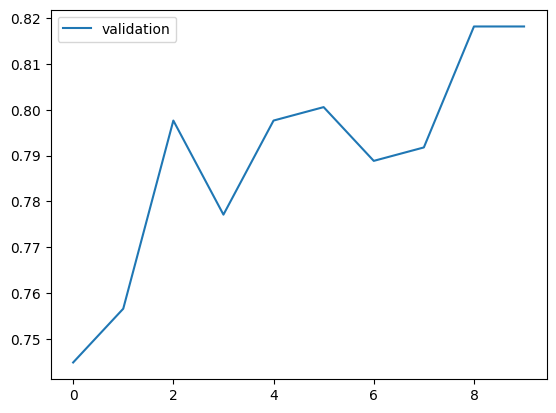

In [32]:
# plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend();

# 8.6 Learning Rate

In [33]:
def make_model(learning_rate=0.01):
    # set include_top false to not include the dense layers in training
    base_model = Xception(weights="imagenet", 
                          include_top=False, 
                          input_shape=(150, 150, 3))
    base_model.trainable = False
    
    ###################################
    ### architecture here(flow of data
    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    outputs = keras.layers.Dense(10)(vectors)
    
    model = keras.Model(inputs, outputs)

    ###################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])
    
    return model

In [34]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    
    model = make_model(lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print("\n\n")

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.2697 - loss: 2.1066 - val_accuracy: 0.4604 - val_loss: 1.6229
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5393 - loss: 1.4406 - val_accuracy: 0.6129 - val_loss: 1.2692
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6258 - loss: 1.1609 - val_accuracy: 0.6745 - val_loss: 1.0886
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6832 - loss: 1.0089 - val_accuracy: 0.7155 - val_loss: 0.9758
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7139 - loss: 0.8929 - val_accuracy: 0.7273 - val_loss: 0.9005
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7393 - loss: 0.8317 - val_accuracy: 0.7419 - val_loss: 0.8503
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7484 - loss: 0.7824 - val_accuracy: 0.7449 - val_loss: 0.8086
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7642 - loss: 0.7478 - val_accuracy: 0.7

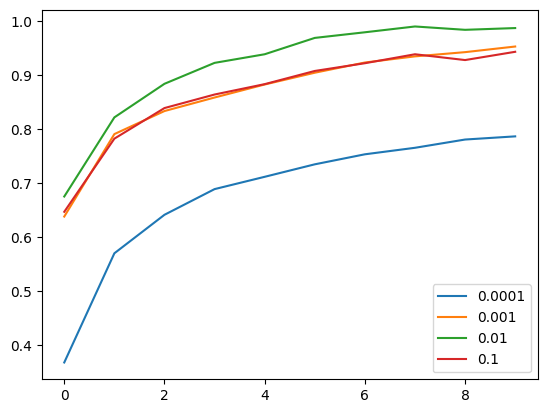

In [35]:
for lr, hst in scores.items():
    plt.plot(hst['accuracy'], label=lr)
plt.legend();

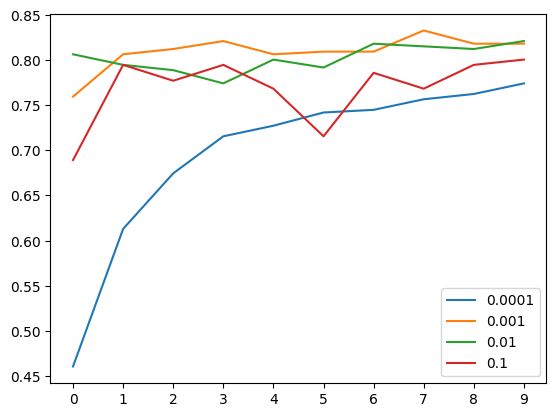

In [36]:
for lr, hst in scores.items():
    plt.plot(hst['val_accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend();

In [37]:
del scores[0.1]
del scores[0.0001]

In [38]:
learning_rate = 0.001

# 8.7 Checkpointing

In [39]:
model

<Functional name=functional_4, built=True>

In [41]:
model.save('model_v1.h5')

In [ ]:
keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5')